<a href="https://colab.research.google.com/github/CesarAugusto88/Registro-automatico-para-CBERS-4/blob/main/Tecnicas_de_Processamento_de_Imagens_para_Registro_Automatico_Aplicacoes_em_PAN_CBERS_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1: Registro automático para CBERS-4 [1].

O objetivo do projeto foi construir um script em Python para estimar o deslocamento existente entre imagens PAN10 e PAN5 (nível L2). Além de estimar, o script deve alterar as informações de box das imagens PAN10 para a mesma posição da PAN5.

O resultado da aplicação desse script será um conjunto de imagens em que seja possível realizar uma fusão. A imagens que utilizou-se como exemplo, foram do satélite CBERS-4, que possui o sensor PAN, com 3 bandas PAN10 (green B2, red B3, nir B4) e 1 banda pancromática (PAN5 B1).

Para atingir o objetivo do trabalho, pode-se assumir que as bandas B2, B3 e B4 estão co-registradas, mas estão deslocadas em relação à B1 (que será a referência). O script pode espalhar pontos aleatórios na imagem, e observar janelas (3x3 pixels, 5x5 pixels, etc), comparando janelas móveis de B2/B3/B4 com janelas fixas de B1. Por meio de deslocamentos sistemáticos das janelas móveis, nos eixos x e/ou y, a posição que obtiver a maior semelhança pode ser indicada como o deslocamento necessário para alinhar B2/B3/B4 com a referência B1.

## Professores:
 - Fabiano Morelli
 - Gilberto Ribeiro
 - Thales Sehn Körting

## Grupo 3:
 - Barbara Marie Van Sebroeck Lutiis S. Martins
 - Cesar Augusto de Moraes Costa
 - Júlio César Pimenta dos Santos
 - Pedro Ferrini Manhães Bacellar
 - Tassio Koiti Igawa


##2: Baixando diretório com imagens para teste

In [1]:
!gdown --id --folder 1-rkI7PGRBMAtv7epvy1q0f7WyiVIZOd4 -q

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


##3: Instalação e importação de bibliotecas



In [2]:
!pip install -q rasterio
!pip install image_registration -q
!pip install -q gdal-utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 27.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.0/330.0 kB 5.6 MB/s eta 0:00:00


In [3]:
import rasterio
from rasterio.enums import Resampling
from osgeo import gdal
from osgeo_utils.gdal_pansharpen import gdal_pansharpen
from pathlib import Path
from matplotlib import pyplot
import matplotlib.pyplot as plt
import skimage
from skimage import io, registration
import numpy as np
from scipy.ndimage import shift
from skimage.transform import warp
from affine import Affine
import image_registration
from image_registration import chi2_shift, cross_correlation_shifts
import cv2

print(rasterio.__version__, gdal.__version__, skimage.__version__)
print(image_registration.__version__, cv2.__version__)

1.3.8 3.4.3 0.19.3
0.2.6 4.8.0


In [4]:
def load_cbers_image(img_dir, bands):
    """
    Função para carregar imagens do CBERS. A função recebe dois parâmetros:
    img_dir: dicionário caminho do diretório das imagens,
    bands: dicionário das bandas referênte ao caminho das imagens.
    """
    # Inicializae os dicionários da imagem e o caminho de fontes dos dados
    image = {}
    ds = {}
    path = Path(img_dir)

    # Laço para percorrer as bandas dadas para carregar
    for band in bands:
        # Imagens CBERS terminam com *.TIF, assim localiza o arquivo correto
        file = next(path.glob(f'*{band}.tif'))
        print(f'Opening file {file}')
        ds.update({band: rasterio.open(file)})
        image.update({band: ds[band].read(1)})

    # print(image, ds)
    return image, ds

In [5]:
# Carregar imagens da função load_cbers_image
img, image_ds = load_cbers_image('/content/Trabalho-Prog-Geo-Registro',
                                    ['CBERS_4_PAN_20230316_194_104_L2_BAND3_crop',
                                   'CBERS_4_PAN_20230316_194_104_L2_BAND2_crop',
                                    'CBERS_4_PAN_20230316_194_104_L2_BAND4_crop'])
# Criar um stack de imagens, nesse caso, NIR_RG
nir_rg = np.stack([img['CBERS_4_PAN_20230316_194_104_L2_BAND4_crop'],
                img['CBERS_4_PAN_20230316_194_104_L2_BAND3_crop'],
                img['CBERS_4_PAN_20230316_194_104_L2_BAND2_crop']], axis=2)
nir_rg = nir_rg / nir_rg.max()

# Carregar bandas B1-PAN e B3-Red
b1_ds = rasterio.open('/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND1_crop.tif')
b3_ds = rasterio.open('/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif')

b1_array = b1_ds.read(1)
b3_array = b3_ds.read(1)


Opening file /content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif
Opening file /content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND2_crop.tif
Opening file /content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND4_crop.tif


In [6]:
# Informar o uso de exceções para a biblioteca gdal
gdal.UseExceptions()

# Abrir o dataset da imagem CBERS
pan = gdal.Open("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND1_crop.tif", gdal.GA_ReadOnly)
red = gdal.Open("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif", gdal.GA_ReadOnly)
green = gdal.Open("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND2_crop.tif", gdal.GA_ReadOnly)
nir = gdal.Open("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND4_crop.tif", gdal.GA_ReadOnly)

# Obter os objetos com as informações das bandas
banda_pan = pan.GetRasterBand(1)
banda_red = red.GetRasterBand(1)
banda_green = green.GetRasterBand(1)
banda_nir = nir.GetRasterBand(1)


## 4: Identificar o Sistema de Referência de Coordenadas

In [7]:
print('Band PAN B1: \n', b1_ds.profile)
print('Band Red  B3: \n', image_ds['CBERS_4_PAN_20230316_194_104_L2_BAND3_crop'].profile)
print('Band Green B2: \n', image_ds['CBERS_4_PAN_20230316_194_104_L2_BAND2_crop'].profile)
print('Band NIR B4: \n', image_ds['CBERS_4_PAN_20230316_194_104_L2_BAND4_crop'].profile)

Band PAN B1: 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 4927, 'height': 4093, 'count': 1, 'crs': CRS.from_epsg(32717), 'transform': Affine(5.0, 0.0, 577310.0,
       0.0, -5.0, 9643180.0), 'blockysize': 1, 'tiled': False, 'interleave': 'band'}
Band Red  B3: 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2465, 'height': 2048, 'count': 1, 'crs': CRS.from_epsg(32717), 'transform': Affine(10.0, 0.0, 577300.0,
       0.0, -10.0, 9643190.0), 'blockysize': 3, 'tiled': False, 'interleave': 'band'}
Band Green B2: 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2465, 'height': 2048, 'count': 1, 'crs': CRS.from_epsg(32717), 'transform': Affine(10.0, 0.0, 577300.0,
       0.0, -10.0, 9643190.0), 'blockysize': 3, 'tiled': False, 'interleave': 'band'}
Band NIR B4: 
 {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 2465, 'height': 2048, 'count': 1, 'crs': CRS.from_epsg(32717), 'transform': Affine(10.0, 0.0, 577300.0,
       0.0, -10.0

##5: Referência para reamostragem (de 5m para 10m)

In [8]:
# Reamostragem da banda Pancromática de 5 para 10 metros - Compatibilizar com as demais bandas

xres, yres = 10, 10

with rasterio.open("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND1_crop.tif") as dataset:
    scale_factor_x = dataset.res[0]/xres
    scale_factor_y = dataset.res[1]/yres

    profile = dataset.profile.copy()
    # Reamostrar os dados para o formato alvo
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * scale_factor_y),
            int(dataset.width * scale_factor_x)
        ),
        resampling=Resampling.bilinear
    )

    # Tranformar a escala da imagem
    transform = dataset.transform * dataset.transform.scale(
        (1 / scale_factor_x),
        (1 / scale_factor_y)
    )
    profile.update({"height": data.shape[-2],
                    "width": data.shape[-1],
                   "transform": transform})

with rasterio.open("output_pan10m.tif", "w", **profile) as dataset:
    dataset.write(data)

In [9]:
raster_pan = '/content/output_pan10m.tif'
pan = gdal.Open(raster_pan)
pan_transf = pan.GetGeoTransform()
print('Pan Transf.:',pan_transf)
print('Pan RasterXSize:',pan.RasterXSize,'Pan RasterYSize',pan.RasterYSize)

raster_green = '/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND2_crop.tif'
green = gdal.Open(raster_green)
green_transf = green.GetGeoTransform()
print('green Transf.:',green_transf)
print('green RasterXSize:',green.RasterXSize,'green RasterYSize:',green.RasterYSize)

raster_red = '/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif'
red = gdal.Open(raster_red)
red_transf = red.GetGeoTransform()
print('red Transf.:',red_transf)
print('red RasterXSize:',red.RasterXSize,'red RasterYSize:',red.RasterYSize)

raster_nir = '/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND4_crop.tif'
nir = gdal.Open(raster_nir)
nir_transf = nir.GetGeoTransform()
print('Nir Transf.:',nir_transf)
print('Nir RasterXSize:',nir.RasterXSize,'Nir RasterYSize:',nir.RasterYSize)

Pan Transf.: (577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)
Pan RasterXSize: 2463 Pan RasterYSize 2046
green Transf.: (577300.0, 10.0, 0.0, 9643190.0, 0.0, -10.0)
green RasterXSize: 2465 green RasterYSize: 2048
red Transf.: (577300.0, 10.0, 0.0, 9643190.0, 0.0, -10.0)
red RasterXSize: 2465 red RasterYSize: 2048
Nir Transf.: (577300.0, 10.0, 0.0, 9643190.0, 0.0, -10.0)
Nir RasterXSize: 2465 Nir RasterYSize: 2048


##6: Registro para Pansharpening (Fusão)

---



### 6.1 Salvar Imagem Composição (NIR-RG)


In [10]:
# Carregar imagens da função load_cbers_image
img, image_ds = load_cbers_image('/content/Trabalho-Prog-Geo-Registro',
                                    ['CBERS_4_PAN_20230316_194_104_L2_BAND3_crop',
                                   'CBERS_4_PAN_20230316_194_104_L2_BAND2_crop',
                                    'CBERS_4_PAN_20230316_194_104_L2_BAND4_crop'])
# Criar um Stack de imagens NIR-RG
nir_rg = np.stack([img['CBERS_4_PAN_20230316_194_104_L2_BAND4_crop'],
                img['CBERS_4_PAN_20230316_194_104_L2_BAND3_crop'],
                img['CBERS_4_PAN_20230316_194_104_L2_BAND2_crop']], axis=2)

Opening file /content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif
Opening file /content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND2_crop.tif
Opening file /content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND4_crop.tif


In [11]:
# Carregar a imagem reamostrada
dataset = gdal.Open("/content/output_pan10m.tif", gdal.GA_ReadOnly)
type(dataset)

osgeo.gdal.Dataset

In [12]:
GT = dataset.GetGeoTransform()
dst_crs='EPSG:32717'

In [13]:
saida_nir_rg = np.float32(nir_rg)

In [14]:
print(GT)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [15]:
transf = (577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)
af_transf = Affine.from_gdal(*transf)
print(af_transf)

| 10.00, 0.00, 577310.00|
| 0.00,-10.00, 9643180.00|
| 0.00, 0.00, 1.00|


In [16]:
saida_nir_rg.shape

(2048, 2465, 3)

In [17]:
with rasterio.open('image_nir_rg.tif', 'w',
                  driver='GTiff',
                  height=saida_nir_rg.shape[0],
                  width=saida_nir_rg.shape[1],
                  count=saida_nir_rg.shape[2],
                  dtype=np.float32,
                  crs=dst_crs,
                  transform=af_transf) as dst:
    # Se a saida_nir_rg está em (y, x, z), ordenar (linha, cols, bands)
    dst.write(np.moveaxis(saida_nir_rg, [0, 1, 2], [1, 2, 0]))

In [18]:
img = gdal.Open('/content/image_nir_rg.tif')
r = img.GetGeoTransform()
print(r)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [19]:
# Abrir o dataset da composição NIRRG, com 3 bandas
dataset = gdal.Open("image_nir_rg.tif", gdal.GA_ReadOnly)

# Obter os objetos com as informações das bandas
banda_nir = dataset.GetRasterBand(1)
banda_red = dataset.GetRasterBand(2)
banda_green = dataset.GetRasterBand(3)

Text(0.5, 1.0, 'Banda 3 - Green')

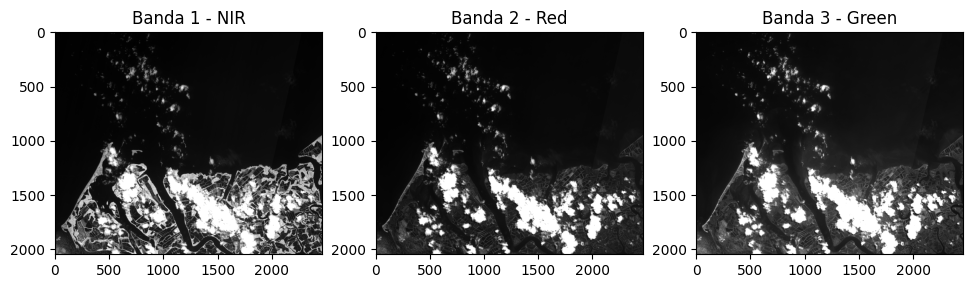

In [20]:
# Obter as matrizes de pixels de cada banda
nir = banda_nir.ReadAsArray()
red = banda_red.ReadAsArray()
green = banda_green.ReadAsArray()

# Combinar bibliotecas GDAL e Matplotlib para visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(nir, cmap='gray')
plt.title('Banda 1 - NIR')
plt.subplot(152)
plt.imshow(red, cmap='gray')
plt.title('Banda 2 - Red')
plt.subplot(153)
plt.imshow(green, cmap='gray')
plt.title('Banda 3 - Green')

###6.2: Pansharpening (fusão) antes do registro

In [21]:
gdal_pansharpen(
    pan_name='/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND1_crop.tif',
    spectral_names=['/content/image_nir_rg.tif'],
    band_nums=[1, 2, 3],
    dst_filename='first_pansharpened.tif')

0

In [22]:
img_array = rasterio.open('/content/first_pansharpened.tif').read()
print(img_array.shape)

(3, 4096, 4930)


(4096, 4930, 3)


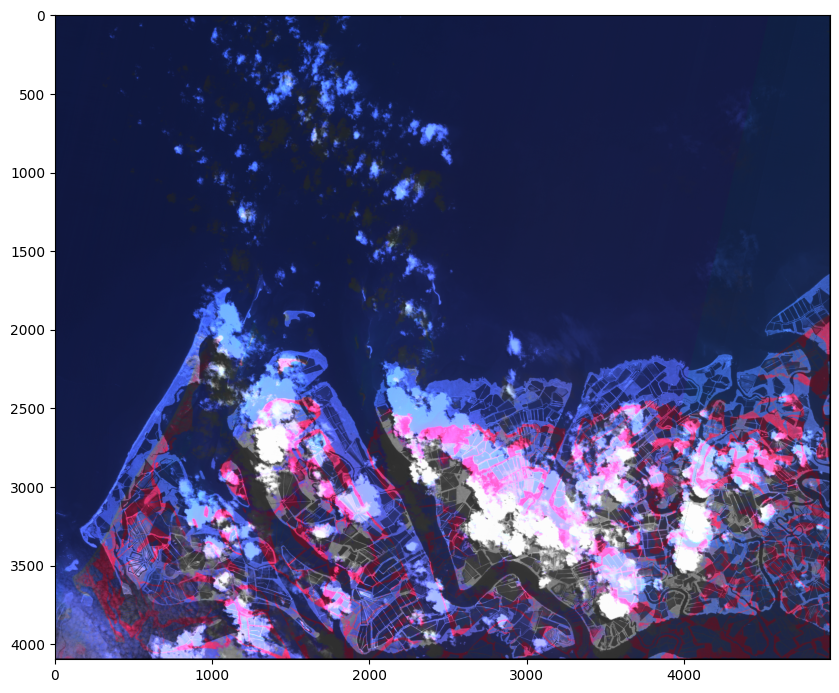

In [23]:
first_pansharp = rasterio.open('/content/first_pansharpened.tif').read()

first_pansharp = np.dstack(first_pansharp)

print(first_pansharp.shape)

first_pansharp_ = first_pansharp / first_pansharp.max()
plt.figure(figsize=(10, 10))
plt.imshow(first_pansharp_)

## 7: Registro com  mudança qui-quadrado (*chi squared shift*)
 - Encontra os deslocamentos entre a imagem 1 e a imagem 2 usando o método de aumento da resolução DFT 2D rígido

In [24]:
image = io.imread("/content/output_pan10m.tif", as_gray=True)

offset_green_image = io.imread("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND2_crop.tif", as_gray=True)
offset_red_image = io.imread("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif", as_gray=True)
offset_nir_image = io.imread("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND4_crop.tif", as_gray=True)

w, h = image.shape

rec_offset_green = offset_green_image[0:w,0:h]  # Recorte com slicing
rec_offset_red = offset_red_image[0:w,0:h]  # Recorte com slicing
rec_offset_nir = offset_nir_image[0:w,0:h]  # Recorte com slicing

# print(image.shape, offset_green_image.shape)
# print(image.shape, rec_offset_green.shape)

#Método 1: chi square green shift (procurar offset_greens entre imagens usando o método DFT) e 2D rigid

noise=0.1
xoff, yoff, exoff, eyoff = chi2_shift(image, rec_offset_red, noise,
                                      return_error=True, upsample_factor='auto')


print("Alteração do Pixels por: ", xoff, yoff)

Alteração do Pixels por:  -20.435546875 147.466796875


In [25]:
corrected_image_green = shift(rec_offset_green, shift=(-yoff, -xoff), mode='constant')
corrected_image_red = shift(rec_offset_red, shift=(-yoff, -xoff), mode='constant')
corrected_image_nir = shift(rec_offset_nir, shift=(-yoff, -xoff), mode='constant')

###7.1: Stack das Imagens Corrigidas (Composição NIR-RG)



In [26]:
# Definir os números de linhas/colunas a partir de alguma matriz da imagem original
#corrected_image_nir,corrected_image_red,corrected_image_green
linhas = corrected_image_green.shape[0]
colunas = corrected_image_green.shape[1]

# Para criar uma visualização em cores verdadeiras, associar as bandas, criar uma matriz com 3 dimensões
array_nir_rg = np.zeros((linhas, colunas, 3))

# Para visualizar corretamente, é necessário dividir as matrizes pelo maior valor, para obter uma matriz com valores normalizados entre 0.0 e 1.0
array_nir_rg[:, :, 0] = corrected_image_nir
array_nir_rg[:, :, 1] = corrected_image_red
array_nir_rg[:, :, 2] = corrected_image_green

In [27]:
array_nir_rg.shape

(2046, 2463, 3)

### 7.2: Salvar imagem nir-rg registrada


In [28]:
dataset = gdal.Open("/content/output_pan10m.tif", gdal.GA_ReadOnly)
type(dataset)

osgeo.gdal.Dataset

In [29]:
GT = dataset.GetGeoTransform()

dst_crs='EPSG:32717'

In [30]:
saida_nir_rg_register = np.float32(array_nir_rg)

In [31]:
print(GT)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [32]:
af_transf = Affine.from_gdal(*GT)
print(af_transf)

| 10.00, 0.00, 577310.00|
| 0.00,-10.00, 9643180.00|
| 0.00, 0.00, 1.00|


In [33]:
saida_nir_rg_register.shape

(2046, 2463, 3)

In [34]:
with rasterio.open('image_nir_rg_register_chi.tif', 'w',
                  driver='GTiff',
                  height=saida_nir_rg_register.shape[0],
                  width=saida_nir_rg_register.shape[1],
                  count=saida_nir_rg_register.shape[2],
                  dtype=np.float32,
                  crs=dst_crs,
                  transform=af_transf) as dst:
    # If saida_nir_rg_register is in (y, x, z) order (rows, cols, bands)
    dst.write(np.moveaxis(saida_nir_rg_register, [0, 1, 2], [1, 2, 0]))

In [35]:
img = gdal.Open('/content/image_nir_rg_register_chi.tif')
r = img.GetGeoTransform()
print(r)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [36]:
# Abrir o dataset
dataset = gdal.Open("/content/image_nir_rg_register_chi.tif", gdal.GA_ReadOnly)

# Obter os objetos com as informações das bandas
banda_nir = dataset.GetRasterBand(1)
banda_red = dataset.GetRasterBand(2)
banda_green = dataset.GetRasterBand(3)


# Imprimir informações de máximos/mínimos, valores dos pixels de cada banda
print(banda_nir.ComputeRasterMinMax())
print(banda_red.ComputeRasterMinMax())
print(banda_green.ComputeRasterMinMax())

(0.0, 255.0)
(0.0, 255.0)
(0.0, 255.0)


Text(0.5, 1.0, 'Banda 2 - Green')

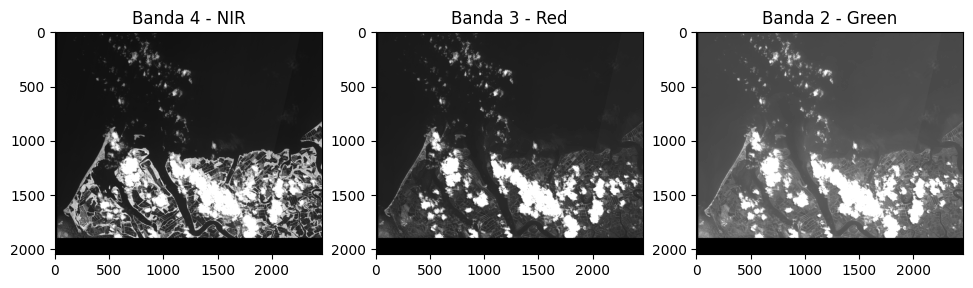

In [37]:
# Obter as matrizes de pixels de cada banda
nir = banda_nir.ReadAsArray()
red = banda_red.ReadAsArray()
green = banda_green.ReadAsArray()

# Combinamos GDAL e Matplotlib para visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(nir, cmap='gray')
plt.title('Banda 4 - NIR')
plt.subplot(152)
plt.imshow(red, cmap='gray')
plt.title('Banda 3 - Red')
plt.subplot(153)
plt.imshow(green, cmap='gray')
plt.title('Banda 2 - Green')

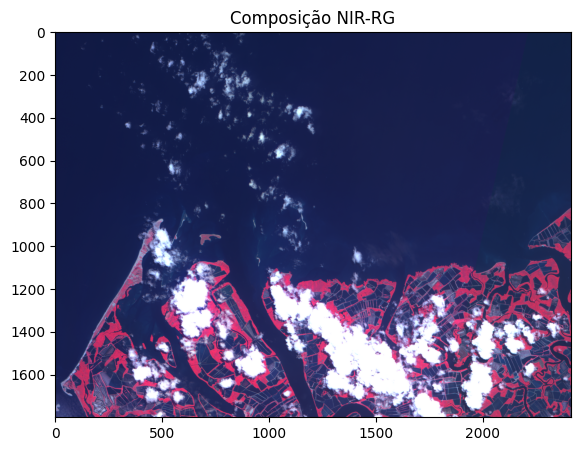

In [38]:
# Definir os números de linhas/colunas a partir de alguma matriz da imagem original
linhas = green.shape[0]
colunas = green.shape[1]

# Para criar uma visualização em cores verdadeiras, associar as bandas, criar uma matriz com 3 dimensões
array_nir_rg = np.zeros((linhas, colunas, 3))

# Para visualizar corretamente, dividir as matrizes pelo maior valor, para obter uma matriz com valores normalizados entre 0.0 e 1.0
array_nir_rg[:, :, 0] = nir / nir.max()
array_nir_rg[:, :, 1] = red / red.max()
array_nir_rg[:, :, 2] = green / green.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_nir_rg[0:1800,50:2500])  # slicing para mostrar
plt.title('Composição NIR-RG');

###7.3: Pansharpening (fusão) depois do registro

In [39]:
# Realizar o pansharpening para GDAL >= 3.3:
# from osgeo.osgeo_utils import gdal_pansharpen
gdal_pansharpen(
    pan_name='/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND1_crop.tif',
    spectral_names=['/content/image_nir_rg_register_chi.tif'],
    band_nums=[1, 2, 3],
    dst_filename='last_pansharpened_chi.tif')

0

In [40]:
img_array = rasterio.open('/content/last_pansharpened_chi.tif').read()
print(img_array.shape)

(3, 4093, 4927)


(4093, 4927, 3)


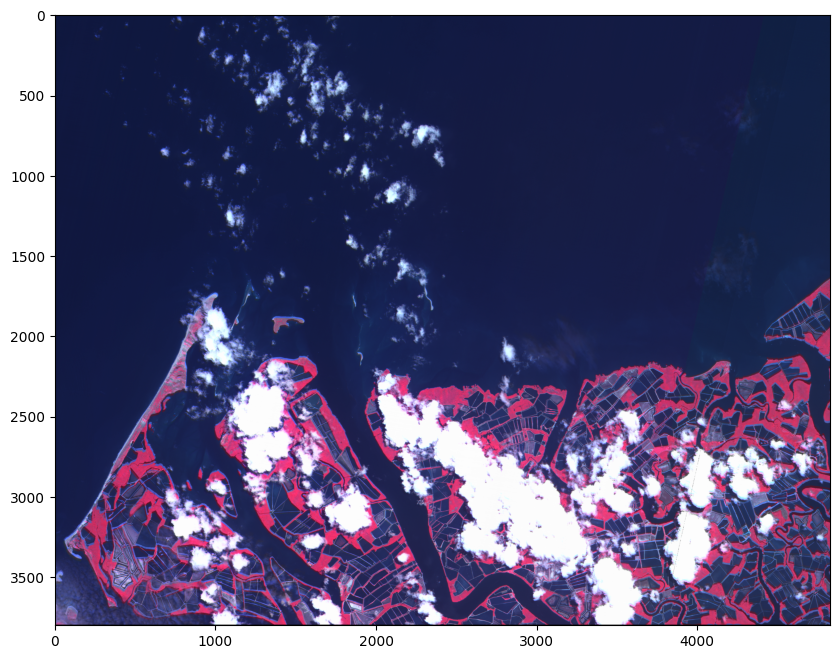

In [41]:
last_pansharp = rasterio.open('/content/last_pansharpened_chi.tif').read()

last_pansharp = np.dstack(last_pansharp)

print(last_pansharp.shape)

last_pansharp_ = last_pansharp / last_pansharp.max()
plt.figure(figsize=(10, 10))
plt.imshow(last_pansharp_[0:3800,100:5000])  # slicing para mostrar

In [42]:
dataset = gdal.Open("/content/last_pansharpened_chi.tif", gdal.GA_ReadOnly)
GT = dataset.GetGeoTransform()
print(GT)

(577310.0, 5.0, 0.0, 9643180.0, 0.0, -5.0)


###7.4: Visualização de fusão anterior e após o registro

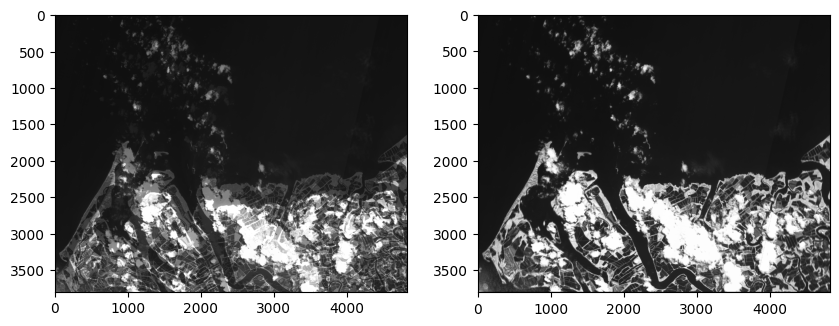

In [43]:
# Plot imagem não registrada e imagem registrada
first_pansharp = rasterio.open('/content/first_pansharpened.tif')
last_pansharp = rasterio.open('/content/last_pansharpened_chi.tif')

first_array = first_pansharp.read(1)
last_array = last_pansharp.read(1)

# Plot as 2 imagens
fig, ax = plt.subplots(1, 2, figsize=(10, 6));
ax[0].imshow(first_array[0:3800,100:5000], cmap='gray')
ax[1].imshow(last_array[0:3800,100:5000], cmap='gray')

(4096, 4930, 3) (4093, 4927, 3)


Text(0.5, 1.0, 'Fusão com registro Chi Square Shift')

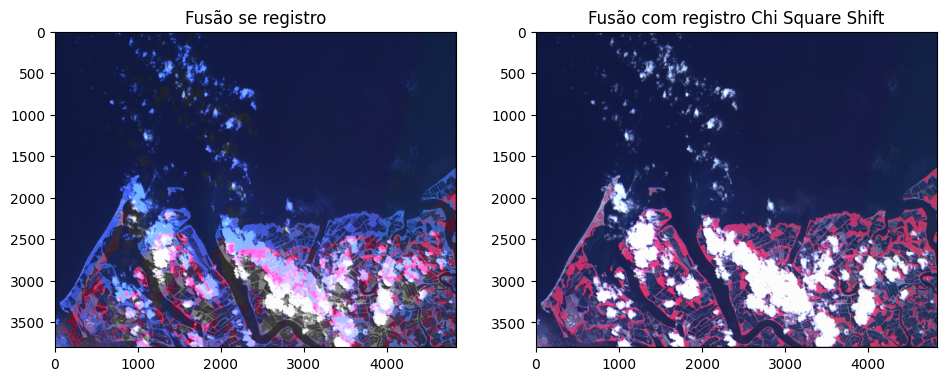

In [44]:
first_pansharp = rasterio.open('/content/first_pansharpened.tif').read()
last_pansharp_chi = rasterio.open('/content/last_pansharpened_chi.tif').read()

first_pansharp = np.dstack(first_pansharp)
last_pansharp_chi = np.dstack(last_pansharp_chi)

print(first_pansharp.shape, last_pansharp_chi.shape)

first_pansharp = first_pansharp / first_pansharp.max()
last_pansharp_chi = last_pansharp_chi / last_pansharp_chi.max()



plt.figure(figsize=(30, 30))
plt.subplot(151)
plt.imshow(first_pansharp[0:3800,100:5000], cmap='gray')
plt.title('Fusão se registro')
plt.subplot(152)
plt.imshow(last_pansharp_chi[0:3800,100:5000], cmap='gray')
plt.title('Fusão com registro Chi Square Shift')


##8: Registro com ORB (*oriented BRIEF*) OpenCV
 - Detector de ponto-chave e extrator de descritor

In [45]:
# Carregar imagens base e alvo

source_image = cv2.imread('output_pan10m.tif', 0)  # Converter para escala de cinza
# BAND3 - Red
target_image = cv2.imread('/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif', 0)  # Idem anterior

In [46]:
# Iniciar a função de detecção e o "extrator"
orb = cv2.ORB_create()

# Procurar pontos homólogos e computar identificadores na imagem base
keypoints_source, descriptors_source = orb.detectAndCompute(source_image, None)
# Procurar pontos homólogos e computar identificadores na imagem alvo
keypoints_target, descriptors_target = orb.detectAndCompute(target_image, None)

In [47]:
# Rodar o "matcher"
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Encontrar homólogos
matches = matcher.match(descriptors_source, descriptors_target)

# Ordenar homólogos por distância
matches = sorted(matches, key=lambda x: x.distance)

# Selecionar X maiores valores de homólogos (podemos alterar o valor 10 pelo número de interesse
top_matches = matches[:10]

# Extrair os pontos homólogos das imagens base e alvo
matched_keypoints_source = np.float32([keypoints_source[m.queryIdx].pt for m in top_matches])
matched_keypoints_target = np.float32([keypoints_target[m.trainIdx].pt for m in top_matches])

In [48]:
# Criar uma matriz dos homólogos usando RANSAC
transformation_matrix, _ = cv2.findHomography(matched_keypoints_source, matched_keypoints_target, cv2.RANSAC, 5.0)

In [49]:
# Ajustar a imagem base e alinhar para a imagem alvo
aligned_image = cv2.warpPerspective(source_image, transformation_matrix, (target_image.shape[1], target_image.shape[0]))

In [50]:
# Calcular a magnitude das diferenças eixo X e eixo Y
size_difference_x = target_image.shape[1] - aligned_image.shape[1]
size_difference_y = target_image.shape[0] - aligned_image.shape[0]

In [51]:
# Extrair os valores de translação das imagens direto da transformation_matrix
translation_x = transformation_matrix[0, 2]
translation_y = transformation_matrix[1, 2]

# Calcular os deltas X e Y
x_difference = size_difference_x + translation_x
y_difference = size_difference_y + translation_y

In [52]:
# Obter os valores dos deltas X e Y

print(x_difference)
print(y_difference)

-27.24420525173148
155.37102812726158


In [53]:
# Mostrar a imagem registrada (matriz e imagem per se)
#print(registered_image)

# Recortar imagem e observar que a área recortada correponde, ao menos em proporções, aos valores dos deltas encontrados
registered_image_green = shift(rec_offset_green, shift=(-y_difference, -x_difference), mode='constant')
registered_image_red = shift(rec_offset_red, shift=(-y_difference, -x_difference), mode='constant')
registered_image_nir = shift(rec_offset_nir, shift=(-y_difference, -x_difference), mode='constant')


###8.1: Stack das Imagens Corrigidas (Composição NIR-RG)

In [54]:
# Definir os números de linhas/colunas a partir de alguma matriz da imagem original
#corrected_image_nir,corrected_image_red,corrected_image_green
linhas = registered_image_green.shape[0]
colunas = registered_image_green.shape[1]

# Para criar uma visualização em cores verdadeiras, associar as bandas, criar uma matriz com 3 dimensões
array_nir_rg_comp = np.zeros((linhas, colunas, 3))

# Para visualizar corretamente, dividir as matrizes pelo maior valor, para obter uma matriz com valores normalizados entre 0.0 e 1.0
array_nir_rg_comp[:, :, 0] = registered_image_nir
array_nir_rg_comp[:, :, 1] = registered_image_red
array_nir_rg_comp[:, :, 2] = registered_image_green

In [55]:
array_nir_rg.shape

(2046, 2463, 3)

### 8.2: Salvar imagem nir-rg registrada

In [56]:
dataset = gdal.Open("/content/output_pan10m.tif", gdal.GA_ReadOnly)
type(dataset)

osgeo.gdal.Dataset

In [57]:
GT = dataset.GetGeoTransform()

dst_crs='EPSG:32717'

In [58]:
saida_nir_rg_comp_register = np.float32(array_nir_rg_comp)

In [59]:
print(GT)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [60]:
af_transf = Affine.from_gdal(*GT)
print(af_transf)

| 10.00, 0.00, 577310.00|
| 0.00,-10.00, 9643180.00|
| 0.00, 0.00, 1.00|


In [61]:
with rasterio.open('image_nir_rg_comp_opencv_register.tif', 'w',
                  driver='GTiff',
                  height=saida_nir_rg_comp_register.shape[0],
                  width=saida_nir_rg_comp_register.shape[1],
                  count=saida_nir_rg_comp_register.shape[2],
                  dtype=np.float32,
                  crs=dst_crs,
                  transform=af_transf) as dst:
    # If saida_nir_rg_register is in (y, x, z) order (rows, cols, bands)
    dst.write(np.moveaxis(saida_nir_rg_comp_register, [0, 1, 2], [1, 2, 0]))

In [62]:
img = gdal.Open('/content/image_nir_rg_comp_opencv_register.tif')
r = img.GetGeoTransform()
print(r)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [63]:
# Abrir o dataset
# NB: ao usar o colab, lembre-se de fazer o upload na aba de arquivos)
dataset = gdal.Open("/content/image_nir_rg_comp_opencv_register.tif", gdal.GA_ReadOnly)

# Obter os objetos com as informações das bandas
banda_nir_cv2 = dataset.GetRasterBand(1)
banda_red_cv2 = dataset.GetRasterBand(2)
banda_green_cv2 = dataset.GetRasterBand(3)


# Imprimir informações de máximos/mínimos, valores dos pixels de cada banda
print(banda_nir_cv2.ComputeRasterMinMax())
print(banda_red_cv2.ComputeRasterMinMax())
print(banda_green_cv2.ComputeRasterMinMax())


(0.0, 255.0)
(0.0, 255.0)
(0.0, 255.0)


Text(0.5, 1.0, 'Banda 2 - Green')

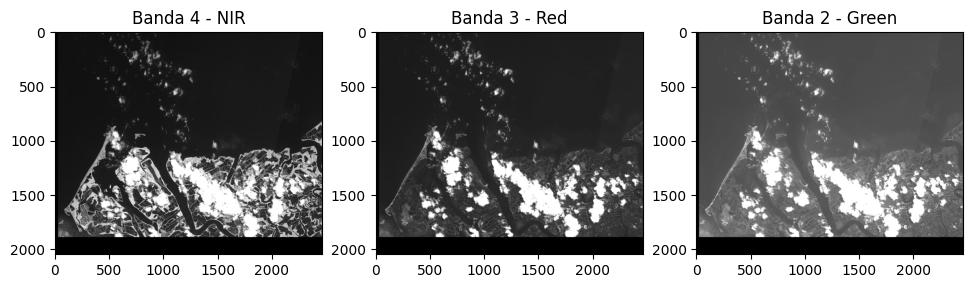

In [64]:
# Obter as matrizes de pixels de cada banda
nir_cv2 = banda_nir_cv2.ReadAsArray()
red_cv2 = banda_red_cv2.ReadAsArray()
green_cv2 = banda_green_cv2.ReadAsArray()

# Combinar GDAL e Matplotlib para visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(nir_cv2, cmap='gray')
plt.title('Banda 4 - NIR')
plt.subplot(152)
plt.imshow(red_cv2, cmap='gray')
plt.title('Banda 3 - Red')
plt.subplot(153)
plt.imshow(green_cv2, cmap='gray')
plt.title('Banda 2 - Green')

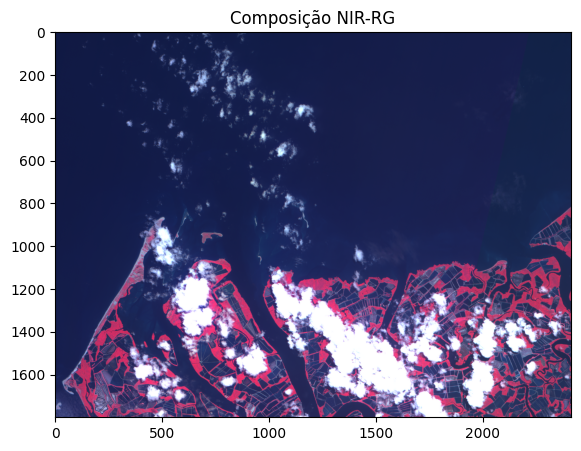

In [65]:
# Definir os números de linhas/colunas a partir de alguma matriz da imagem original
linhas = green_cv2.shape[0]
colunas = green_cv2.shape[1]

# Para criar uma visualização em cores verdadeiras, associar as bandas, criar uma matriz com 3 dimensões
array_nir_rg_cv2 = np.zeros((linhas, colunas, 3))

# Para visualizar corretamente, dividir as matrizes pelo maior valor, para obter uma matriz com valores normalizados entre 0.0 e 1.0
array_nir_rg_cv2[:, :, 0] = nir_cv2 / nir_cv2.max()
array_nir_rg_cv2[:, :, 1] = red_cv2 / red_cv2.max()
array_nir_rg_cv2[:, :, 2] = green_cv2 / green_cv2.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_nir_rg_cv2[0:1800,50:2500])
plt.title('Composição NIR-RG');


###8.3: Pansharpening (fusão) depois do registro

In [66]:
# Pansharpening
gdal_pansharpen(
    pan_name='/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND1_crop.tif',
    spectral_names=['/content/image_nir_rg_comp_opencv_register.tif'],
    band_nums=[1, 2, 3],
    dst_filename='last_pansharpened_cv2_orb.tif')

0

In [67]:
img_array_cv2 = rasterio.open('/content/last_pansharpened_cv2_orb.tif').read()
print(img_array_cv2.shape)


(3, 4093, 4927)


(4093, 4927, 3)


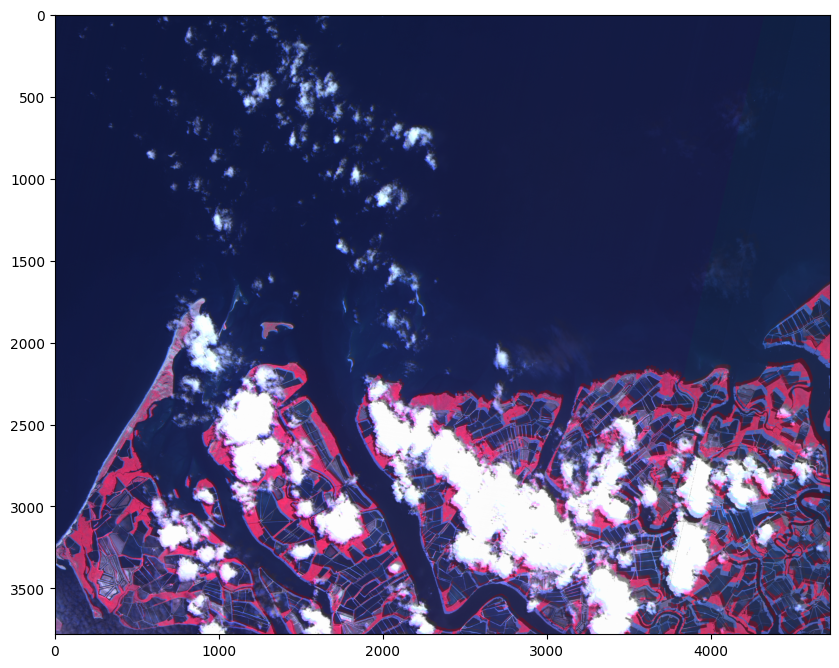

In [68]:
last_pansharp_cv2 = rasterio.open('/content/last_pansharpened_cv2_orb.tif').read()

last_pansharp_cv2 = np.dstack(last_pansharp_cv2)

print(last_pansharp_cv2.shape)

last_pansharp_cv2 = last_pansharp_cv2 / last_pansharp_cv2.max()
plt.figure(figsize=(10, 10))
plt.imshow(last_pansharp_cv2[0:3780,200:5000])

In [69]:
dataset_cv2 = gdal.Open("/content/last_pansharpened_cv2_orb.tif", gdal.GA_ReadOnly)
GT_cv2 = dataset_cv2.GetGeoTransform()
print(GT_cv2)

(577310.0, 5.0, 0.0, 9643180.0, 0.0, -5.0)


###8.4: Visualização de fusão anterior e após o registro

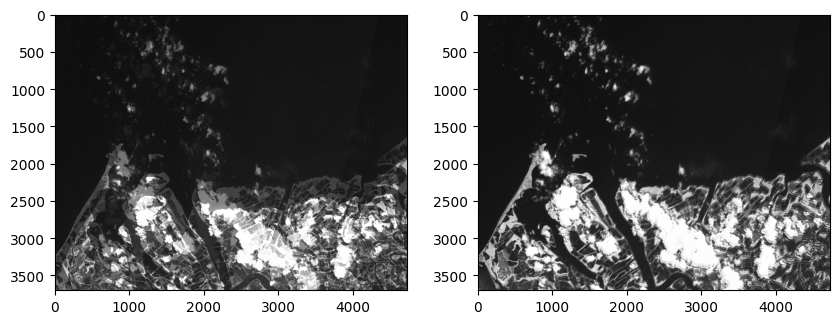

In [70]:
# Plot imagem não registrada e imagem registrada
first_pansharp_cv2 = rasterio.open('/content/first_pansharpened.tif')
last_pansharp_cv2 = rasterio.open('/content/last_pansharpened_cv2_orb.tif')

first_array_cv2 = first_pansharp_cv2.read(1)
last_array_cv2 = last_pansharp_cv2.read(1)

# Plotar as 2 imagens
fig, ax = plt.subplots(1, 2, figsize=(10, 6));
ax[0].imshow(first_array_cv2[0:3700,200:5000], cmap='gray')
ax[1].imshow(last_array_cv2[0:3700,200:5000], cmap='gray')

(4096, 4930, 3) (4093, 4927, 3)


Text(0.5, 1.0, 'Fusão com registro ORB OpenCV')

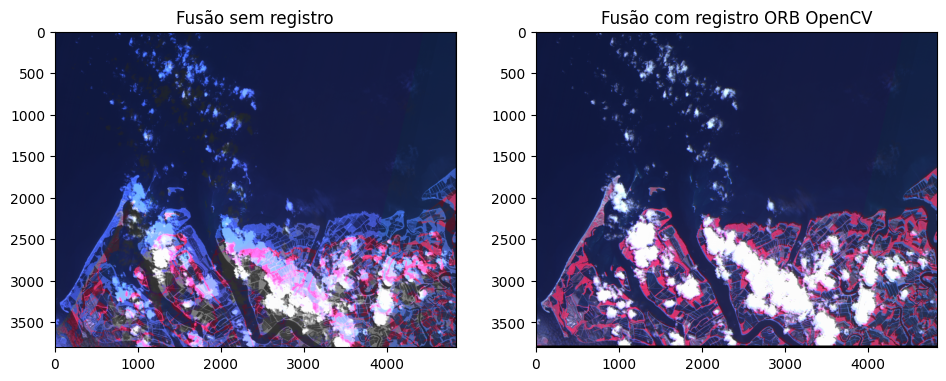

In [71]:
first_pansharp_cv2 = rasterio.open('/content/first_pansharpened.tif').read()
last_pansharp_cv2 = rasterio.open('/content/last_pansharpened_cv2_orb.tif').read()

first_pansharp_cv2 = np.dstack(first_pansharp_cv2)
last_pansharp_cv2 = np.dstack(last_pansharp_cv2)

print(first_pansharp_cv2.shape, last_pansharp_cv2.shape)

first_pansharp_cv2 = first_pansharp_cv2 / first_pansharp_cv2.max()
last_pansharp_cv2 = last_pansharp_cv2 / last_pansharp_cv2.max()

# Plot the 2 images
# fig, ax = plt.subplots(1, 2, figsize=(14, 14));
# ax[0].imshow(first_pansharp_cv2[0:3800,100:5000], cmap='gray')
# ax[1].imshow(last_pansharp_cv2[0:3800,100:5000], cmap='gray')

plt.figure(figsize=(30, 20))
plt.subplot(151)
plt.imshow(first_pansharp_cv2[0:3800,100:5000], cmap='gray')
plt.title('Fusão sem registro')
plt.subplot(152)
plt.imshow(last_pansharp_cv2[0:3800,100:5000], cmap='gray')
plt.title('Fusão com registro ORB OpenCV')

## 9: Registro com Optical Flow Based Shift
- Optical flow based shift (Mudança baseada em fluxo óptico).
- Melhor para imagens distorcidas.
- Pega duas imagens e retorna um campo vetorial.
- Para cada pixel na imagem 1 obtém-se um vetor mostrando para onde ele foi movido na imagem 2.

In [72]:
image = io.imread("/content/output_pan10m.tif", as_gray=True)

offset_green_image = io.imread("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND2_crop.tif", as_gray=True)
offset_red_image = io.imread("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND3_crop.tif", as_gray=True)
offset_nir_image = io.imread("/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND4_crop.tif", as_gray=True)

w, h = image.shape
# w, h = w-10, h-10
print(w,h)

rec_offset_green = offset_green_image[0:w,0:h]  # Recorte com slicing
rec_offset_red = offset_red_image[0:w,0:h]  # Recorte com slicing
rec_offset_nir = offset_nir_image[0:w,0:h]  # Recorte com slicing

# print(image.shape, offset_green_image.shape)
# print(image.shape, rec_offset_green.shape)


flow = registration.optical_flow_tvl1(image, rec_offset_nir)

# display dense optical flow
flow_x = flow[1, :, :]  #Along width
flow_y = flow[0, :, :]  #Along height


#Simple application by just taking mean of flow in x and y
#Let us find the mean of all pixels in x and y and shift image by that amount
#ideally, you need to move each pixel by the amount from flow
import numpy as np
xoff = np.mean(flow_x)
yoff = np.mean(flow_y)


# print("Offset image was translated by: 18, -17")
print("Pixels shifted by: ", xoff, yoff)

2046 2463
Pixels shifted by:  -12.680027 134.59189


In [73]:
corrected_image_green = shift(rec_offset_green, shift=(-yoff, -xoff), mode='constant')
corrected_image_red = shift(rec_offset_red, shift=(-yoff, -xoff), mode='constant')
corrected_image_nir = shift(rec_offset_nir, shift=(-yoff, -xoff), mode='constant')

###9.1: Stack das Imagens Corrigidas (Composição NIR-RG)



In [74]:
# Definir os números de linhas/colunas a partir de alguma matriz da imagem original
#corrected_image_nir,corrected_image_red,corrected_image_green
linhas = corrected_image_nir.shape[0]
colunas = corrected_image_nir.shape[1]

# Para criar uma visualização em cores verdadeiras, associar as bandas, criar uma matriz com 3 dimensões
array_nir_rg = np.zeros((linhas, colunas, 3))

# Para visualizar corretamente, é necessário dividir as matrizes pelo maior valor, para obter uma matriz com valores normalizados entre 0.0 e 1.0
array_nir_rg[:, :, 0] = corrected_image_nir
array_nir_rg[:, :, 1] = corrected_image_red
array_nir_rg[:, :, 2] = corrected_image_green

In [75]:
array_nir_rg.shape

(2046, 2463, 3)

### 9.2: Salvar imagem nir-rg registrada


In [76]:
dataset = gdal.Open("/content/output_pan10m.tif", gdal.GA_ReadOnly)
type(dataset)

osgeo.gdal.Dataset

In [77]:
GT = dataset.GetGeoTransform()

dst_crs='EPSG:32717'

In [78]:
saida_nir_rg_register = np.float32(array_nir_rg)

In [79]:
print(GT)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [80]:
af_transf = Affine.from_gdal(*GT)
print(af_transf)

| 10.00, 0.00, 577310.00|
| 0.00,-10.00, 9643180.00|
| 0.00, 0.00, 1.00|


In [81]:
saida_nir_rg_register.shape

(2046, 2463, 3)

In [82]:
with rasterio.open('image_nir_rg_register_optical.tif', 'w',
                  driver='GTiff',
                  height=saida_nir_rg_register.shape[0],
                  width=saida_nir_rg_register.shape[1],
                  count=saida_nir_rg_register.shape[2],
                  dtype=np.float32,
                  crs=dst_crs,
                  transform=af_transf) as dst:
    # If saida_nir_rg_register is in (y, x, z) order (rows, cols, bands)
    dst.write(np.moveaxis(saida_nir_rg_register, [0, 1, 2], [1, 2, 0]))

In [83]:
img = gdal.Open('/content/image_nir_rg_register_optical.tif')
r = img.GetGeoTransform()
print(r)

(577310.0, 10.0, 0.0, 9643180.0, 0.0, -10.0)


In [84]:
# Abrir o dataset
dataset = gdal.Open("/content/image_nir_rg_register_optical.tif", gdal.GA_ReadOnly)

# Obter os objetos com as informações das bandas
banda_nir = dataset.GetRasterBand(1)
banda_red = dataset.GetRasterBand(2)
banda_green = dataset.GetRasterBand(3)


# Imprimir informações de máximos/mínimos, valores dos pixels de cada banda
print(banda_nir.ComputeRasterMinMax())
print(banda_red.ComputeRasterMinMax())
print(banda_green.ComputeRasterMinMax())

(0.0, 255.0)
(0.0, 255.0)
(0.0, 255.0)


Text(0.5, 1.0, 'Banda 2 - Green')

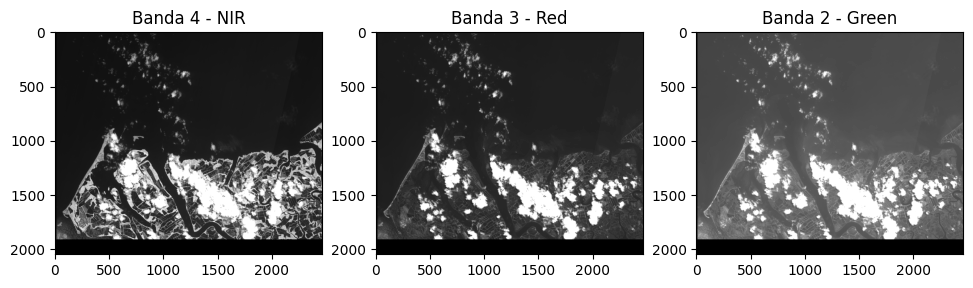

In [85]:
# Obter as matrizes de pixels de cada banda
nir = banda_nir.ReadAsArray()
red = banda_red.ReadAsArray()
green = banda_green.ReadAsArray()

# Combinamos GDAL e Matplotlib para visualizar as bandas individualmente
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(nir, cmap='gray')
plt.title('Banda 4 - NIR')
plt.subplot(152)
plt.imshow(red, cmap='gray')
plt.title('Banda 3 - Red')
plt.subplot(153)
plt.imshow(green, cmap='gray')
plt.title('Banda 2 - Green')

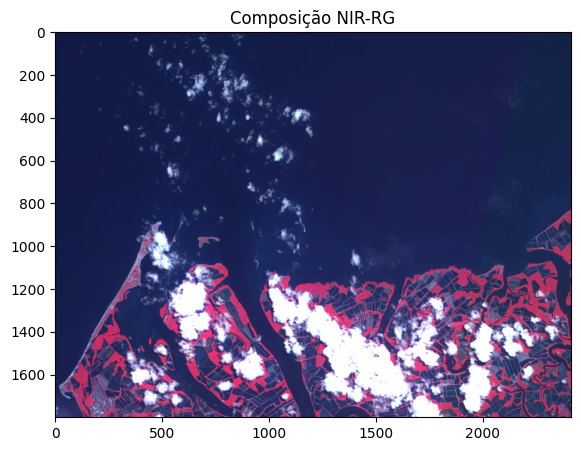

In [86]:
# Definir os números de linhas/colunas a partir de alguma matriz da imagem original
linhas = green.shape[0]
colunas = green.shape[1]

# Para criar uma visualização em cores verdadeiras, associar as bandas, criar uma matriz com 3 dimensões
array_nir_rg = np.zeros((linhas, colunas, 3))

# Para visualizar corretamente, dividir as matrizes pelo maior valor, para obter uma matriz com valores normalizados entre 0.0 e 1.0
array_nir_rg[:, :, 0] = nir / nir.max()
array_nir_rg[:, :, 1] = red / red.max()
array_nir_rg[:, :, 2] = green / green.max()

plt.figure(figsize=(20, 5))
plt.imshow(array_nir_rg[0:1800,50:2500])  # slicing para mostrar
plt.title('Composição NIR-RG');

###9.3: Pansharpening (fusão) depois do registro

In [87]:
# Realizar o pansharpening para GDAL >= 3.3:
# from osgeo.osgeo_utils import gdal_pansharpen
gdal_pansharpen(
    pan_name='/content/Trabalho-Prog-Geo-Registro/CBERS_4_PAN_20230316_194_104_L2_BAND1_crop.tif',
    spectral_names=['/content/image_nir_rg_register_optical.tif'],
    band_nums=[1, 2, 3],
    dst_filename='last_pansharpened_optical.tif')

0

In [88]:
img_array = rasterio.open('/content/last_pansharpened_optical.tif').read()

print(img_array.shape)

(3, 4093, 4927)


(4093, 4927, 3)


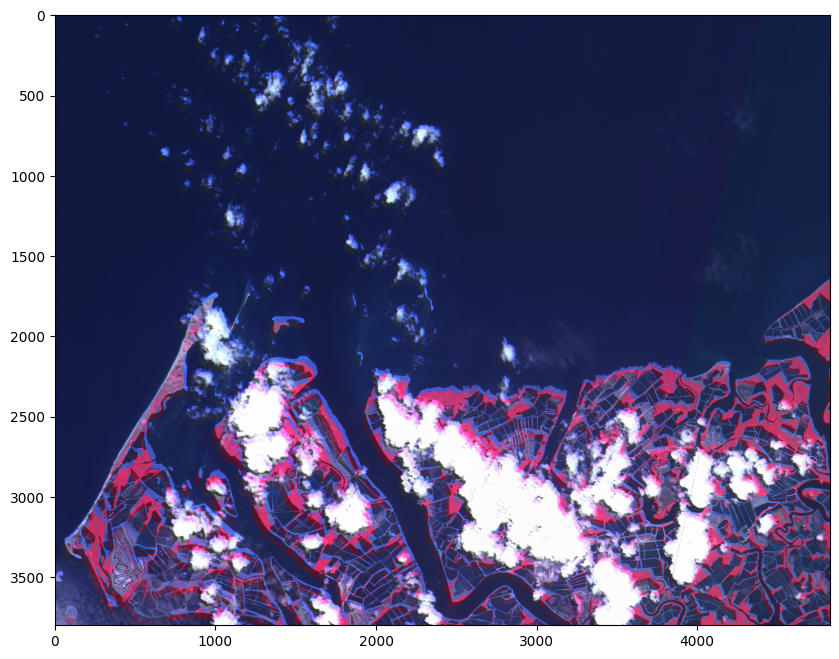

In [89]:
last_pansharp = rasterio.open('/content/last_pansharpened_optical.tif').read()

last_pansharp = np.dstack(last_pansharp)

print(last_pansharp.shape)

last_pansharp_ = last_pansharp / last_pansharp.max()
plt.figure(figsize=(10, 10))
plt.imshow(last_pansharp_[0:3800,100:5000])  # slicing para mostrar

In [90]:
dataset = gdal.Open("/content/last_pansharpened_optical.tif", gdal.GA_ReadOnly)
GT = dataset.GetGeoTransform()
print(GT)

(577310.0, 5.0, 0.0, 9643180.0, 0.0, -5.0)


###9.4: Visualização de fusão anterior e após o registro

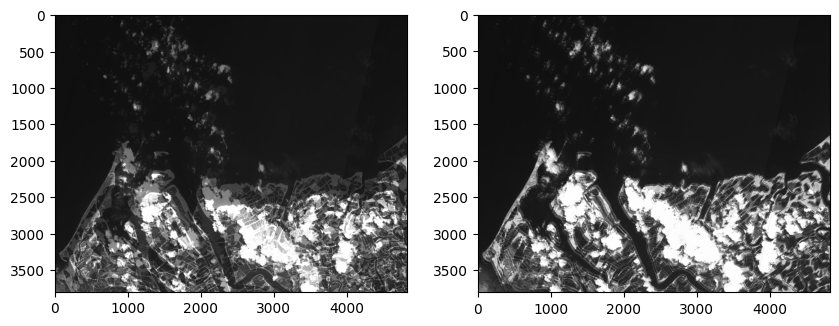

In [91]:
# Plot imagem não registrada e imagem registrada
first_pansharp = rasterio.open('/content/first_pansharpened.tif')
last_pansharp = rasterio.open('/content/last_pansharpened_optical.tif')

first_array = first_pansharp.read(1)
last_array = last_pansharp.read(1)

# Plot as 2 imagens
fig, ax = plt.subplots(1, 2, figsize=(10, 6));
ax[0].imshow(first_array[0:3800,100:5000], cmap='gray')
ax[1].imshow(last_array[0:3800,100:5000], cmap='gray')

(4096, 4930, 3) (4093, 4927, 3)


Text(0.5, 1.0, 'Fusão com registro Optical Flow Based Shift')

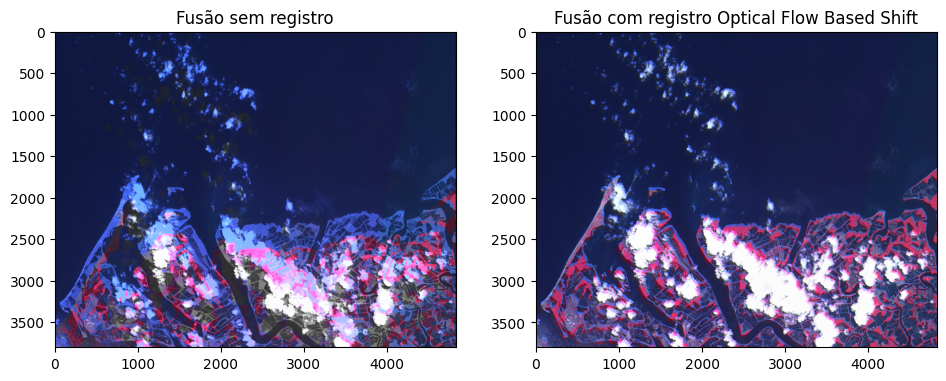

In [92]:
first_pansharp = rasterio.open('/content/first_pansharpened.tif').read()
last_pansharp_optical = rasterio.open('/content/last_pansharpened_optical.tif').read()

first_pansharp = np.dstack(first_pansharp)
last_pansharp_optical = np.dstack(last_pansharp_optical)

print(first_pansharp.shape, last_pansharp_optical.shape)

first_pansharp = first_pansharp / first_pansharp.max()
last_pansharp_optical = last_pansharp_optical / last_pansharp_optical.max()

plt.figure(figsize=(30, 30))
plt.subplot(151)
plt.imshow(first_pansharp[0:3800,100:5000], cmap='gray')
plt.title('Fusão sem registro')
plt.subplot(152)
plt.imshow(last_pansharp_optical[0:3800,100:5000], cmap='gray')
plt.title('Fusão com registro Optical Flow Based Shift')


## 10: Visualização dos dos três métodos de registros

Text(0.5, 1.0, 'Fusão com registro Optical Flow Based Shift')

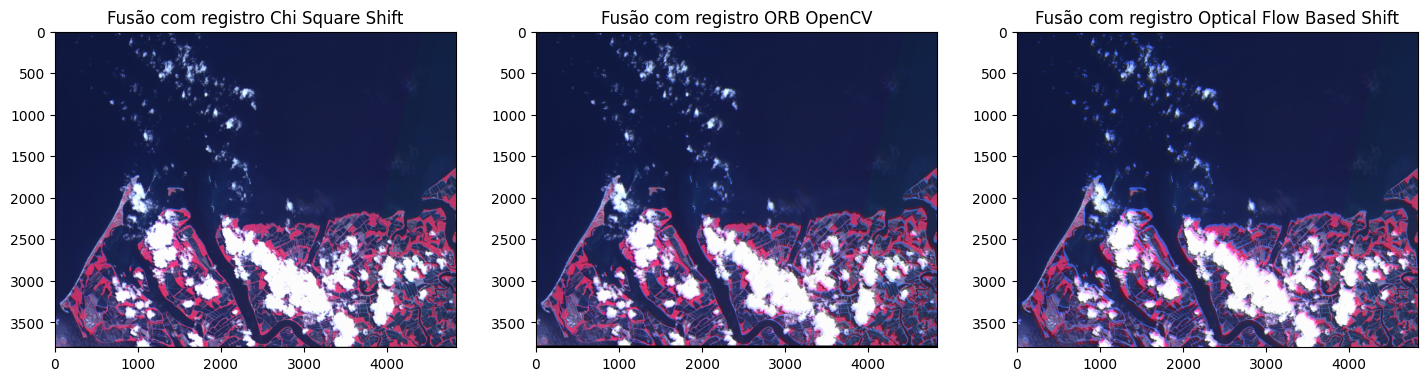

In [113]:
# Combinando Matplotlib para visualizar registros
plt.figure(figsize=(30, 30))
plt.subplot(151)
plt.imshow(last_pansharp_chi[0:3800,100:5000], cmap='gray')
plt.title('Fusão com registro Chi Square Shift')
plt.subplot(152)
plt.imshow(last_pansharp_cv2[0:3800,100:5000], cmap='gray')
plt.title('Fusão com registro ORB OpenCV')
plt.subplot(153)
plt.imshow(last_pansharp_optical[0:3800,100:5000], cmap='gray')
plt.title('Fusão com registro Optical Flow Based Shift')

# Referências:
 - [1] [Registro automático para CBERS-4](https://prog-geo.github.io/projetos/2023/p01-registro.html#registro-automatico-para-cbers-4)
